# Regression for Count Data

In [1]:
import os

# Change the current working directory
os.chdir('files')

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

### Part a): Load and clean data
Kaggle: https://www.kaggle.com/datasets/amalab182/property-salesmelbourne-city

In [3]:
# Load the property sales
df = pd.read_csv('Property Sales of Melbourne City.csv',low_memory=False)
df.head()

,Unnamed: 0,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,1,Abbotsford,85 Turner St,2,h,1480000,S,Biggin,3/12/2016,2.50000,...,1.00000,1.00000,202.00000,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.00000
1,2,Abbotsford,25 Bloomburg St,2,h,1035000,S,Biggin,4/02/2016,2.50000,...,1.00000,0.00000,156.00000,79.00000,1900.00000,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.00000
2,4,Abbotsford,5 Charles St,3,h,1465000,SP,Biggin,4/03/2017,2.50000,...,2.00000,0.00000,134.00000,150.00000,1900.00000,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.00000
3,5,Abbotsford,40 Federation La,3,h,850000,PI,Biggin,4/03/2017,2.50000,...,2.00000,1.00000,94.00000,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.00000
4,6,Abbotsford,55a Park St,4,h,1600000,VB,Nelson,4/06/2016,2.50000,...,1.00000,2.00000,120.00000,142.00000,2014.00000,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.00000


It's a prediction of number of rooms in the property. Bathroom or Bedroom 2 are not considered as the relationship is clearly strong, as they provide amount of rooms as well. The considered variables are  price, landsize and the distance to the Melbourne central business district, year built, Region name and type. 

In [4]:
# Predict the property rooms

df = df[['Rooms', 'Price', 'Distance', 'Landsize', 'YearBuilt', 'Type', 'Regionname']]

# Ensure that the variables are numeric
df['Distance'] = pd.to_numeric(df['Distance'])
df['Landsize'] = pd.to_numeric(df['Landsize'] )
df['Rooms'] = pd.to_numeric(df['Rooms'])
df['Price'] = pd.to_numeric(df['Price'])
df['YearBuilt'] = pd.to_numeric(df['YearBuilt'])
type_dum = pd.get_dummies(df['Type']).astype(int)
region_dum = pd.get_dummies(df['Regionname']).astype(int)
df = pd.concat([df, type_dum, region_dum], axis=1)
df = df.drop(columns={'Type', 'Regionname'})

df = df.dropna()


df.head()

,Rooms,Price,Distance,Landsize,YearBuilt,h,t,u,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
1,2,1035000,2.50000,156.00000,1900.00000,1,0,0,0,0,1,0,0,0,0,0
2,3,1465000,2.50000,134.00000,1900.00000,1,0,0,0,0,1,0,0,0,0,0
4,4,1600000,2.50000,120.00000,2014.00000,1,0,0,0,0,1,0,0,0,0,0
6,3,1876000,2.50000,245.00000,1910.00000,1,0,0,0,0,1,0,0,0,0,0
7,2,1636000,2.50000,256.00000,1890.00000,1,0,0,0,0,1,0,0,0,0,0


Text(0, 0.5, 'Frequency')

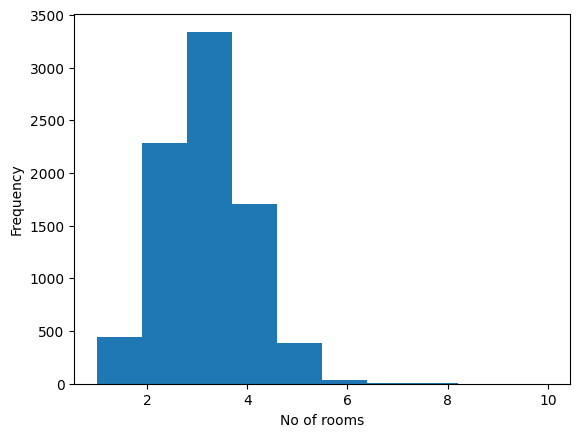

In [5]:
# Plot the histogram
plt.hist(df['Rooms'])
plt.xlabel('No of rooms')
plt.ylabel('Frequency')

##### Answer: 
The distribution of room numbers is skewed to the right, with a peak between 0 and 1.

#### Take the log. What can you say about the resulting distribution ? 

Text(0, 0.5, 'Frequency')

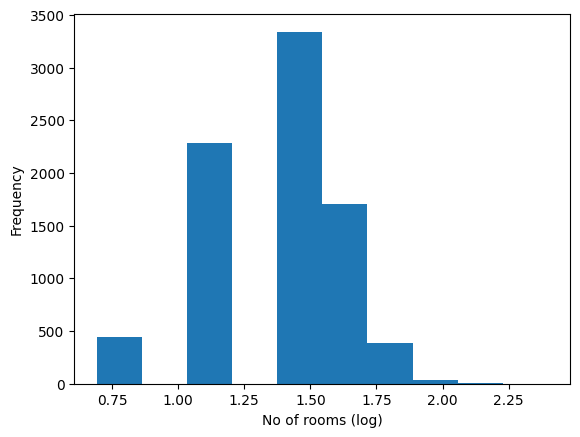

In [6]:
# Take the log + 1 to avoid log(0)
rooms_log = np.log(df['Rooms'] + 1)

plt.hist(rooms_log)
plt.xlabel('No of rooms (log)')
plt.ylabel('Frequency')

##### Answer: 

This distribution is not skewed anymore. It resembles a normal distrbution.

### Part b): Linear Regression


### Create your design matrix and you dependent variable vector.

In [7]:
# Drop rows with missing values
data_cleaned = df.dropna()

# Dependent variable
y_cleaned = data_cleaned['Rooms']
y_log_cleaned = np.log(data_cleaned['Rooms']+1)
# Design matrix
X_cleaned = data_cleaned.drop(columns=['Rooms'])

In [8]:
X_cleaned

,Price,Distance,Landsize,YearBuilt,h,t,u,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
1,1035000,2.50000,156.00000,1900.00000,1,0,0,0,0,1,0,0,0,0,0
2,1465000,2.50000,134.00000,1900.00000,1,0,0,0,0,1,0,0,0,0,0
4,1600000,2.50000,120.00000,2014.00000,1,0,0,0,0,1,0,0,0,0,0
6,1876000,2.50000,245.00000,1910.00000,1,0,0,0,0,1,0,0,0,0,0
7,1636000,2.50000,256.00000,1890.00000,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18388,1245000,16.70000,652.00000,1981.00000,1,0,0,0,0,0,0,1,0,0,0
18389,1031000,6.80000,333.00000,1995.00000,1,0,0,0,0,0,0,0,0,1,0
18390,1170000,6.80000,436.00000,1997.00000,1,0,0,0,0,0,0,0,0,1,0
18392,2500000,6.80000,866.00000,1920.00000,1,0,0,0,0,0,0,0,0,1,0


In [9]:
# Drop variables with 0 variability 
# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_cleaned)
# Get the columns 
X_encoded_var_filtered = X_cleaned.iloc[:, selector.get_support(indices=True)]

In [10]:
# Calculate the correlation matrix
corr_matrix = X_encoded_var_filtered.abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

In [11]:
# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

In [12]:
# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

#### iv. Fit a linear regression model to the data. Print the summary and a histogram of the residuals. Is it normally distributed ? 

In [13]:
# Adding a constant for the intercept
X_encoded_with_const = sm.add_constant(X_train_scaled)

In [14]:
# Fitting the linear regression model
model = sm.OLS(y_cleaned, X_encoded_with_const).fit()

# Displaying the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rooms   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     722.4
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:38:01   Log-Likelihood:                -8887.8
No. Observations:                8213   AIC:                         1.780e+04
Df Residuals:                    8202   BIC:                         1.787e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

(array([   1.,    3.,   76., 2655., 4716.,  723.,   29.,    6.,    3.,
           1.]),
 array([-5.08753, -3.87798, -2.66843, -1.45888, -0.24932,  0.96023,
         2.16978,  3.37933,  4.58889,  5.79844,  7.00799]),
 <BarContainer object of 10 artists>)

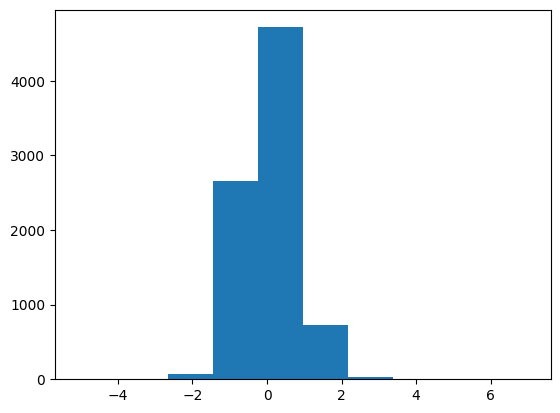

In [15]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals)

The residuals are looking almost as normally distributed

#### v. Simulate 1000 values from the joint posterior distribution of the regression coefficients. 

In [16]:
# extract regression coefficients and covariance matrix
coef = model.params
cov_matrix = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean= coef, cov = cov_matrix, size = n_simulations)

#### vi. Use a `violin plot` to display the distrubution and point-estimates of the most `statistically significant` coefficients. To pick the most significant coefficients, you can use a rule of thumb as harsh as Pr(beta>0)>0.975 | Pr(beta>0)<0.025, or as laxed as Pr(beta>0)>0.8 | Pr(beta>0)<0.2.

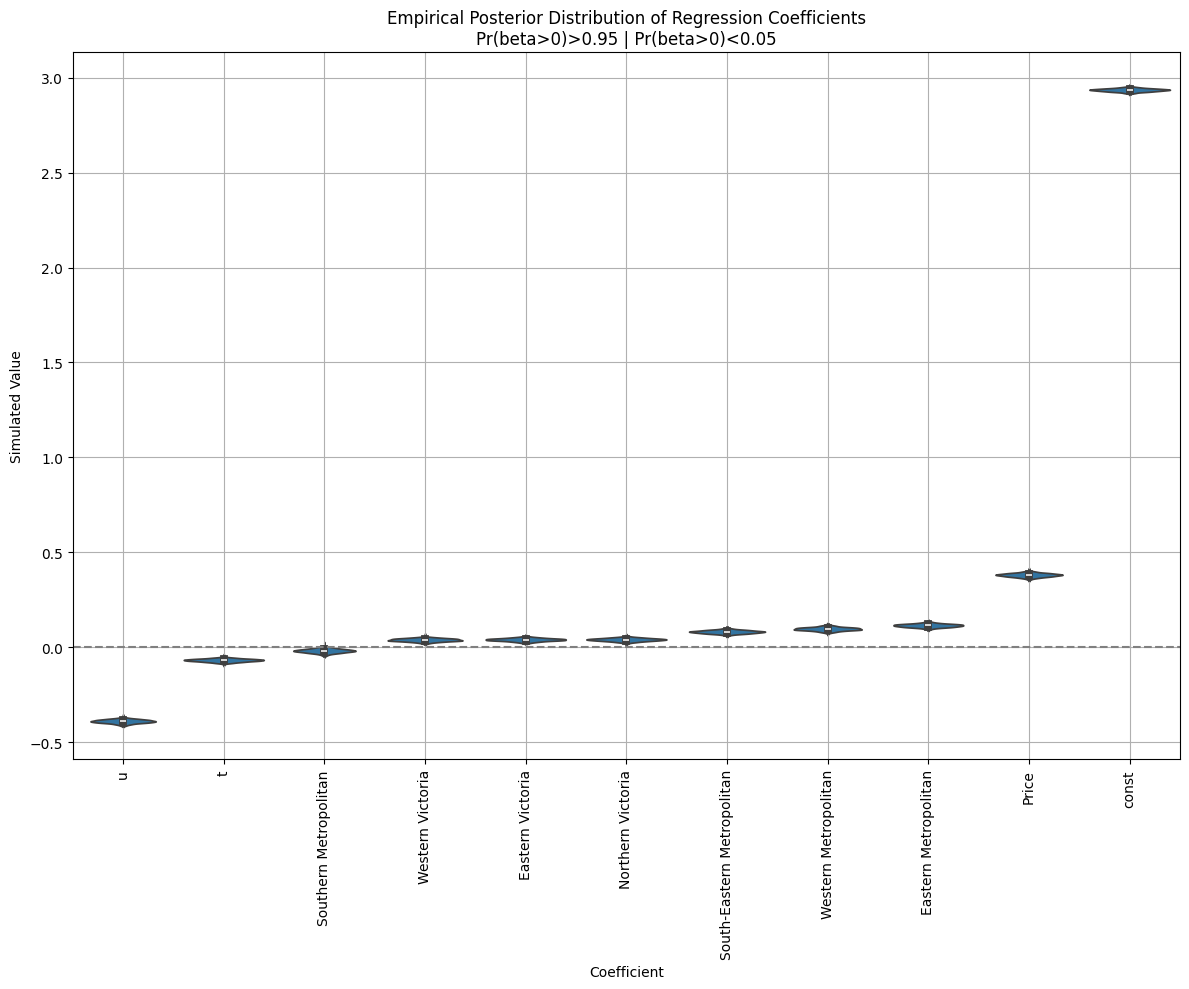

In [17]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')

# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

#### vii. Draw 1000 samples from the posterior predictive distribution of $y$. 

In [18]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate =  np.dot(X_encoded_with_const, beta_simulation)
    predicted_counts[i] = np.random.normal(predicted_rate,np.sqrt(model.scale))

#### viii. Calculate the monte-carlo medians and prediction intervals. Based on these, calculate the point estimate correlation, rmse, bias and coverage. 

In [19]:
monte_carlo_medians = np.median(predicted_counts, axis = 0)
prediction_intervals = np.percentile(predicted_counts,[2.5, 97.5], axis = 0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

#### ix. Plot the predicted values against the observed values of $y$. Display the error metrics above in the legend. 

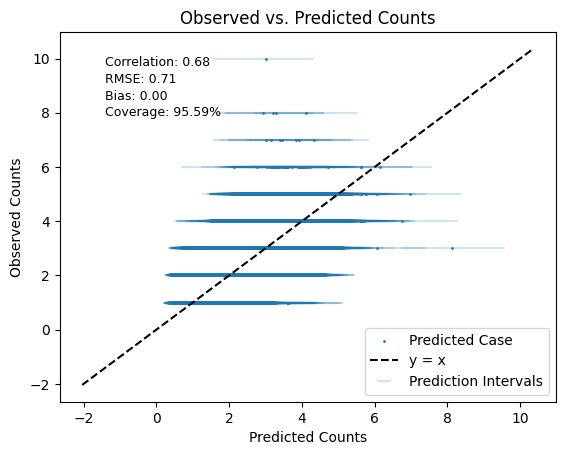

In [20]:
# Find overall min and max for xlim and ylim
# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()
# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])


# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


### Part c): Log-Linear Regression

Repeat the above from the model fitting onwards, but change the dependent variable to be on the log-scale. Apply any transformation you see fit to achieve this. 

In [21]:
model = sm.OLS(y_log_cleaned, X_encoded_with_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rooms   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     802.1
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:38:06   Log-Likelihood:                 2244.2
No. Observations:                8213   AIC:                            -4466.
Df Residuals:                    8202   BIC:                            -4389.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

(array([   1.,    3.,   30.,  393., 1488., 4633., 1533.,  122.,    7.,
           3.]),
 array([-1.22923, -1.00268, -0.77612, -0.54957, -0.32301, -0.09646,
         0.1301 ,  0.35665,  0.58321,  0.80976,  1.03632]),
 <BarContainer object of 10 artists>)

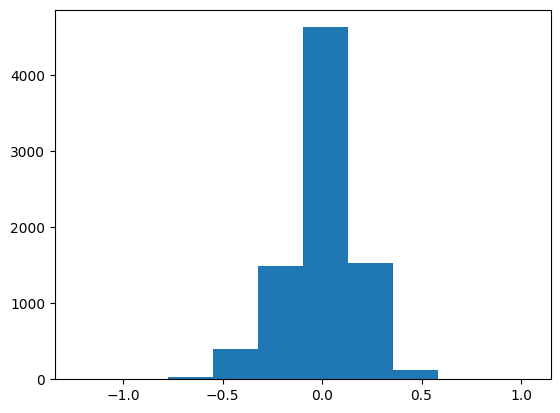

In [22]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals)

In [23]:
# extract regression coefficients and covariance matrix
coef = model.params
cov_matrix = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean = coef, cov = cov_matrix, size = n_simulations)

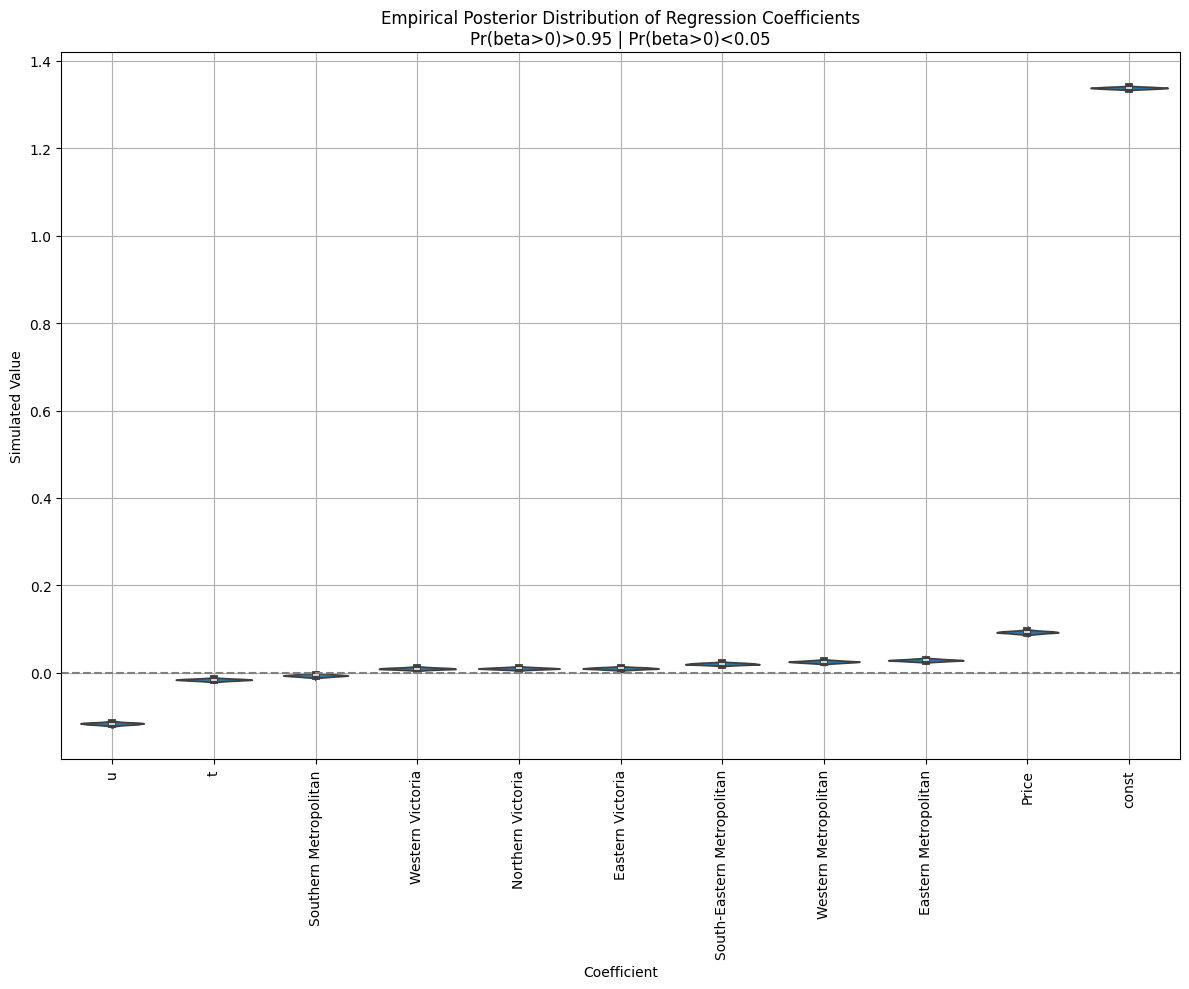

In [24]:

# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')

# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [25]:
# Initialize an array to store predictions from each simulation
predicted_counts =  np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [26]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_log_rate = np.dot(X_encoded_with_const, beta_simulation)
    # Simulate from the posterior-predictive distribution 
    predicted_counts[i] = np.exp(predicted_log_rate)

In [27]:
monte_carlo_medians = np.median(predicted_counts, axis = 0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis =0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))


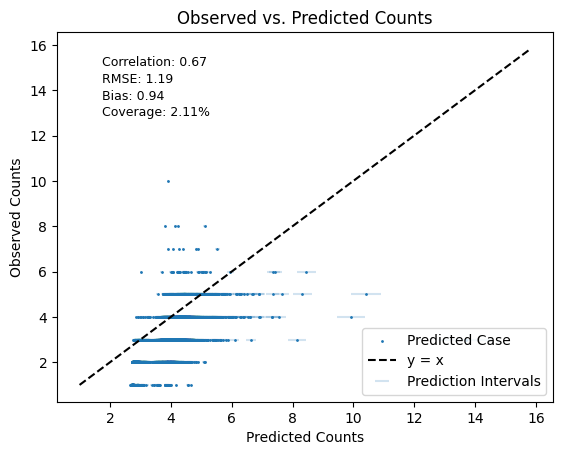

In [28]:
# Find overall min and max for xlim and ylim
# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()
# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])


# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()

### Part d): Poisson Regression

Repeat the above from the model fitting onwards, but change the distribution of the depedent variable from normal to Poisson. You can fit a poisson regression using the GLM module of the statsmodels library. Comment on which of the three regression models is most useful for this application and why. 

In [29]:
from statsmodels.api import GLM, Poisson

In [30]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(y_cleaned, X_encoded_with_const, family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

C:\Users\majak\AppData\Local\Temp\ipykernel_19388\453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Rooms   No. Observations:                 8213
Model:                            GLM   Df Residuals:                     8202
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12706.
Date:                Tue, 02 Apr 2024   Deviance:                       1454.1
Time:                        11:38:11   Pearson chi2:                 1.45e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1453
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [31]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

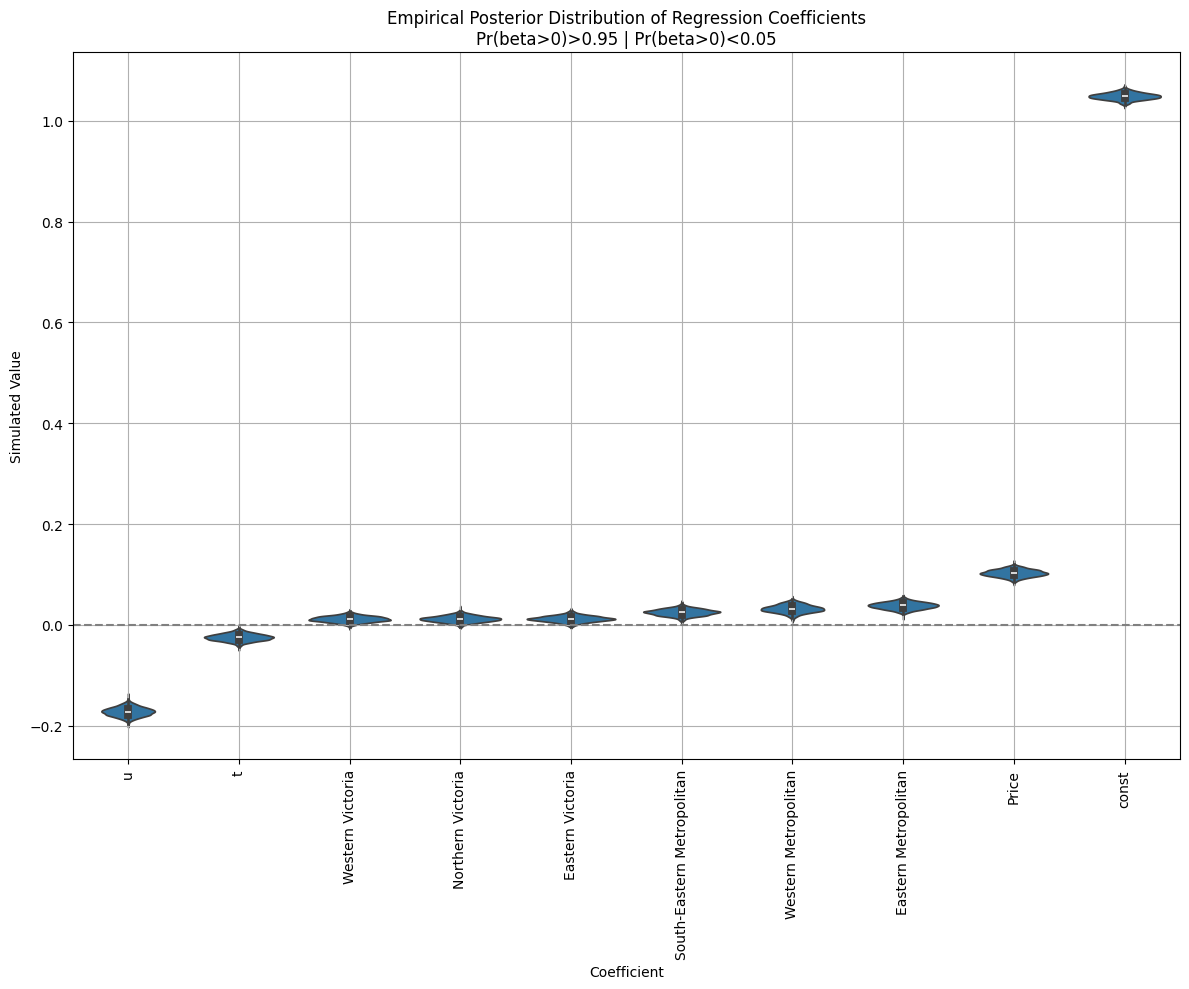

In [32]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [33]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [34]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(X_encoded_with_const, beta_simulation))
    predicted_counts[i] = np.random.poisson(predicted_rate)

In [35]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

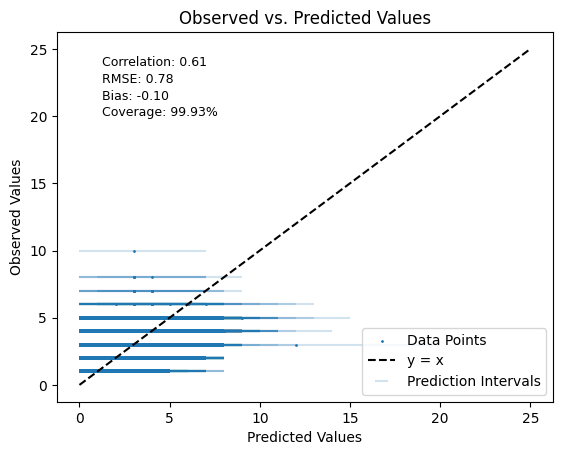

In [36]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()


##### Answer: 

The best pperforming model is the linear regression. It has the shortest prediction intervals, smallest bias, and lowest RMS.